In [1]:
# General imports
import pandas as pd, numpy as np, gc as gc, re, random, warnings, traceback, time, string
warnings.filterwarnings('ignore')
from joblib import dump, load

# Class imbalance rectification
from sklearn.svm import SVC
# from sklearn.decomposition import PCA, TruncatedSVD # imported later
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, RepeatedEditedNearestNeighbours, NearMiss
from imblearn.over_sampling import ADASYN, SVMSMOTE

# Optimization
import optuna

# Classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron, RidgeClassifier, SGDClassifier, LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from treeinterpreter import treeinterpreter as ti

# Dimensionality Reduction and remapping
from umap import UMAP
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Scalers
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

from pandas_profiling import ProfileReport

# Testing imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, confusion_matrix, f1_score
from training_utils import collect_metrics,  collect_gsc_metrics, print_distro, print_metrics, dummy_encode, retrieve_data, probability_plot
import shap
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from plot_metric.functions import BinaryClassification

# plot imports
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt  
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import shap

In [2]:
# Read in the data
df = pd.read_csv('raw_data.csv')

In [3]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [166]:
report.to_file("report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Fill in some null values
df['Priority'].fillna('No Priority Listed', inplace=True)
df["General_Contractor"].fillna('No General Contractor Listed', inplace=True)
df['Remarks'].fillna('', inplace=True)
df['EST'].fillna('No Estimator Listed', inplace=True)
df['Addendum'].fillna('No Addendum', inplace=True)
# Change to boolean
df['Addendum'] = [1 if x != 'No Addendum' else 0 for x in df['Addendum']]

# Strip whitespace, fill in null values
df['Results'] = [str(x).strip() for x in df['Results']]
df['Results'].fillna('No Result Listed', inplace=True)

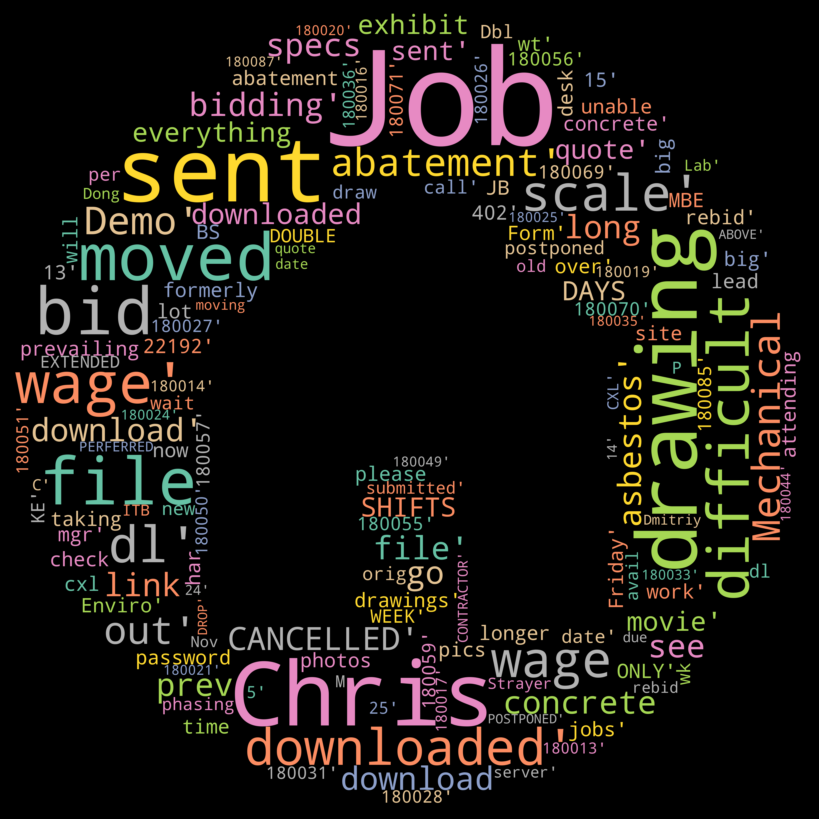

In [5]:
house_mask = np.array(Image.open("house_mask.png"))
text = df['Remarks'].values 

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=house_mask).generate(str(text))
plt.figure(figsize=(8, 8), facecolor="k")
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig("dabbco_wordcloud.png", format="png") 
plt.show()

In [6]:
# Text cleaning function
def get_words(para):   
    # Declare regex pattern, nltk defined stop words, and a Snowball stemmer
    pattern = '([\d]|[\d][\d])\/([\d]|[\d][\d]\/([\d]{4}))'
    #stop_words = load('stop_words.joblib')
    stop_words = stop_nltk
    stemmer = SnowballStemmer('english')
    
    # Remove dates
    no_integers = [re.sub(pattern, '', i) for i in para.lower().split()]
    # Remove puncutation
    no_punctuation = [nopunc.translate(str.maketrans('', '', string.punctuation)) for nopunc in no_integers]
    # Remove non stop words
    dirty_tokens = [data for data in no_integers if data not in stop_words]
    
    # No empty spaces
    tokens = [data for data in dirty_tokens if data.strip()]
    
    # No single character "words"
    tokens = [data for data in tokens if len(data) > 1]
    
    # Stem the remaining tokens
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    # Return them
    return stemmed_tokens

stop_nltk = stopwords.words('english')

In [7]:
# Get the text data for just no defect
s = pd.Series(df['Remarks'])
corpus = s.apply(lambda s: ' '.join(get_words(s)))
text = ' '.join(corpus)

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                      colormap='Set3', collocations=False, stopwords = STOPWORDS, mask=house_mask).generate(text)

# Plot
plt.figure()
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("dabbco_wordcloud.png", format="png") 
plt.show()

KeyboardInterrupt: 

In [61]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [83]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['Remarks_cleaned'] = df['Remarks'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
df

Due_By            Priority Bid_Sent Bid_Sender  Bid_Sender_Num Bid_Num  \
0     1-Jun  No Priority Listed      NaN        NaN             NaN  18-330   
1     1-Jun  No Priority Listed      NaN        NaN             NaN  18-306   
2     1-Jun  No Priority Listed      NaN        NaN             NaN  18-306   
3     1-Jun  No Priority Listed      NaN        NaN             NaN  18-306   
4     1-Jun  No Priority Listed      NaN        NaN             NaN  18-337   
..      ...                 ...      ...        ...             ...     ...   
612  27-Dec  No Priority Listed      NaN        NaN             NaN     NaN   
613     NaN  No Priority Listed      NaN        NaN             NaN     NaN   
614     NaN  No Priority Listed      NaN        NaN             NaN     NaN   
615  29-Dec  No Priority Listed      NaN        NaN             NaN     NaN   
616  29-Dec  No Priority Listed      NaN        NaN             NaN     NaN   

              Time                          Job_Name    File  Status  ...  \
0              NaN              101 S Charles Street  #NAME?     NaN  ...   
1    11:30:00 A.M.  Additive Manufacturing Expansion  #NAME?     NaN  ...   
2     2:00:00 P.M.  Additive Manufacturing Expansion  #NAME?     NaN  ...   
3     3:00:00 P.M.  Additive Manufacturing Expansion  #NAME?     NaN  ...   
4     5:00:00 P.M.            Auto Zone Owings Mills  #NAME?     NaN  ...   
..             ...                               ...     ...     ...  ...   
612   2:00:00 P.M.          GBMC Crisis Intervention  #NAME?     NaN  ...   
613            NaN                               NaN  #NAME?     NaN  ...   
614            NaN                               NaN  #NAME?     NaN  ...   
615  10:00:00 A.M.                   Jimmy's Seafood  #NAME?     NaN  ...   
616   2:00:00 P.M.               Autograph Playhouse  #NAME?     NaN  ...   

               General_Contractor Addendum  Remarks                  EST   WT  \
0            Schaefer Contracting        0           No Estimator Listed  NaN   
1               Lewis Contractors        0                         DS KE  NaN   
2                         Manekin        0           No Estimator Listed  NaN   
3            North Point Builders        0           No Estimator Listed  NaN   
4            Visible Construction        0           No Estimator Listed  NaN   
..                            ...      ...      ...                  ...  ...   
612    Metropolitan Builders, Inc        0                            KE  NaN   
613              Plano-Coudon LLC        0           No Estimator Listed  NaN   
614      Strayer Contracting, Inc        0                            KE  NaN   
615  No General Contractor Listed        0           No Estimator Listed  NaN   
616              Plano-Coudon LLC        0           No Estimator Listed  NaN   

      TE  MBE    %      Results Remarks_cleaned  
0    NaN  NaN  NaN          nan                  
1    NaN  NaN  NaN      Awarded                  
2    NaN  NaN  NaN  Not Awarded                  
3    NaN  NaN  NaN  Not Awarded                  
4    NaN  NaN  NaN          nan                  
..   ...  ...  ...          ...             ...  
612  NaN  NaN  NaN          nan                  
613  NaN  NaN  NaN          nan                  
614  NaN  NaN  NaN          nan                  
615  NaN  NaN  NaN          nan                  
616  NaN  NaN  NaN          nan                  

[617 rows x 21 columns]

In [8]:
matplotlib.rc_file_defaults()

job 24
sent 10
chris 8
wage 6
drawings 6
downloaded 5
abatement 4
download 4
file 4
dl 4
moved 4
bid 4
difficult 3
concrete 3
scale 3
mechanical 3
demo 3
quote 3
go 2
bidding 2


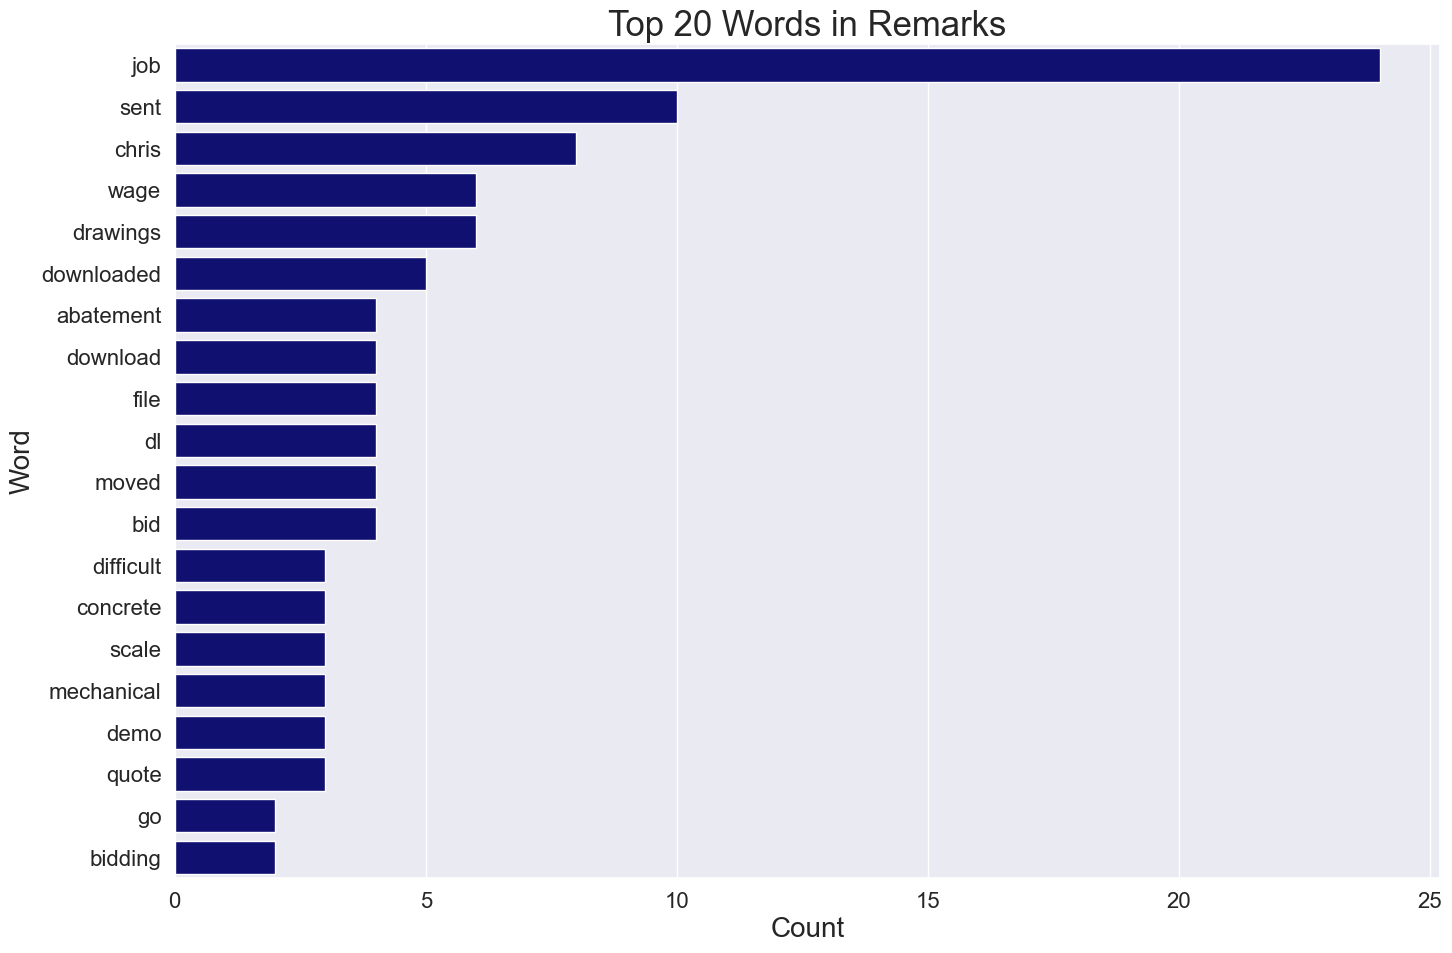

In [134]:
common_words = get_top_n_words(df['Remarks_cleaned'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['description Text' , 'count'])

sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="count", y="description Text", data=df1, color = 'navy', orient = 'h')
plt.title('Top 20 Words in Remarks', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Count',fontsize=20)
plt.ylabel('Word',fontsize=20)
plt.tight_layout(pad=2)
plt.savefig("dabbco_topwords.png", format="png") 

chris sent 6
wage scale 3
mechanical demo 3
sent quote 3
drawings downloaded 2
difficult files 2
files dl 2
long download 2
prev wage 2
80 asbestos 2
downloaded everything 2
everything movie 2
shifts days 2
jb longer 1
longer bidding 1
chris desk 1
desk 11 1
abatement site 1
site work 1
mbe form 1


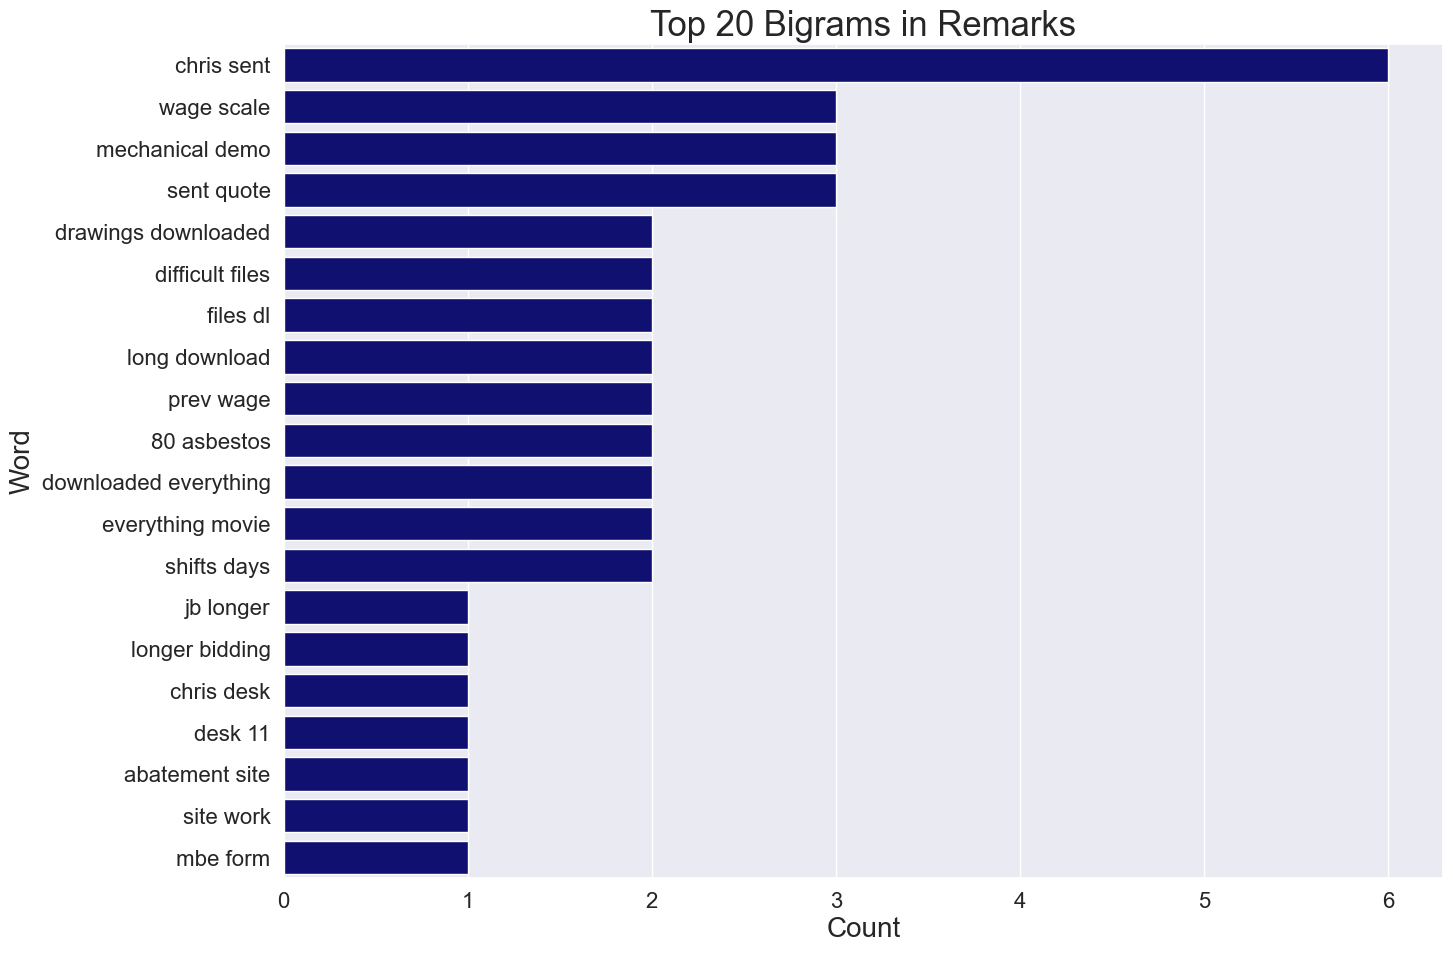

In [135]:
common_words = get_top_n_bigram(df['Remarks_cleaned'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['description Text' , 'count'])

sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="count", y="description Text", data=df1, color = 'navy', orient = 'h')
plt.title('Top 20 Bigrams in Remarks', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Count',fontsize=20)
plt.ylabel('Word',fontsize=20)
plt.tight_layout(pad=2)
plt.savefig("dabbco_topbigrams.png", format="png")

difficult files dl 2
downloaded everything movie 2
chris sent quote 2
jb longer bidding 1
chris desk 11 1
abatement site work 1
difficult download please 1
download please check 1
please check file 1
formerly 18 402 1
see drawings specs 1
unable download drawings 1
lot photos downloaded 1
drawings long download 1
file taking long 1
taking long download 1
har time dl 1
cxl now rebid 1
link pics big 1
chris will bid 1


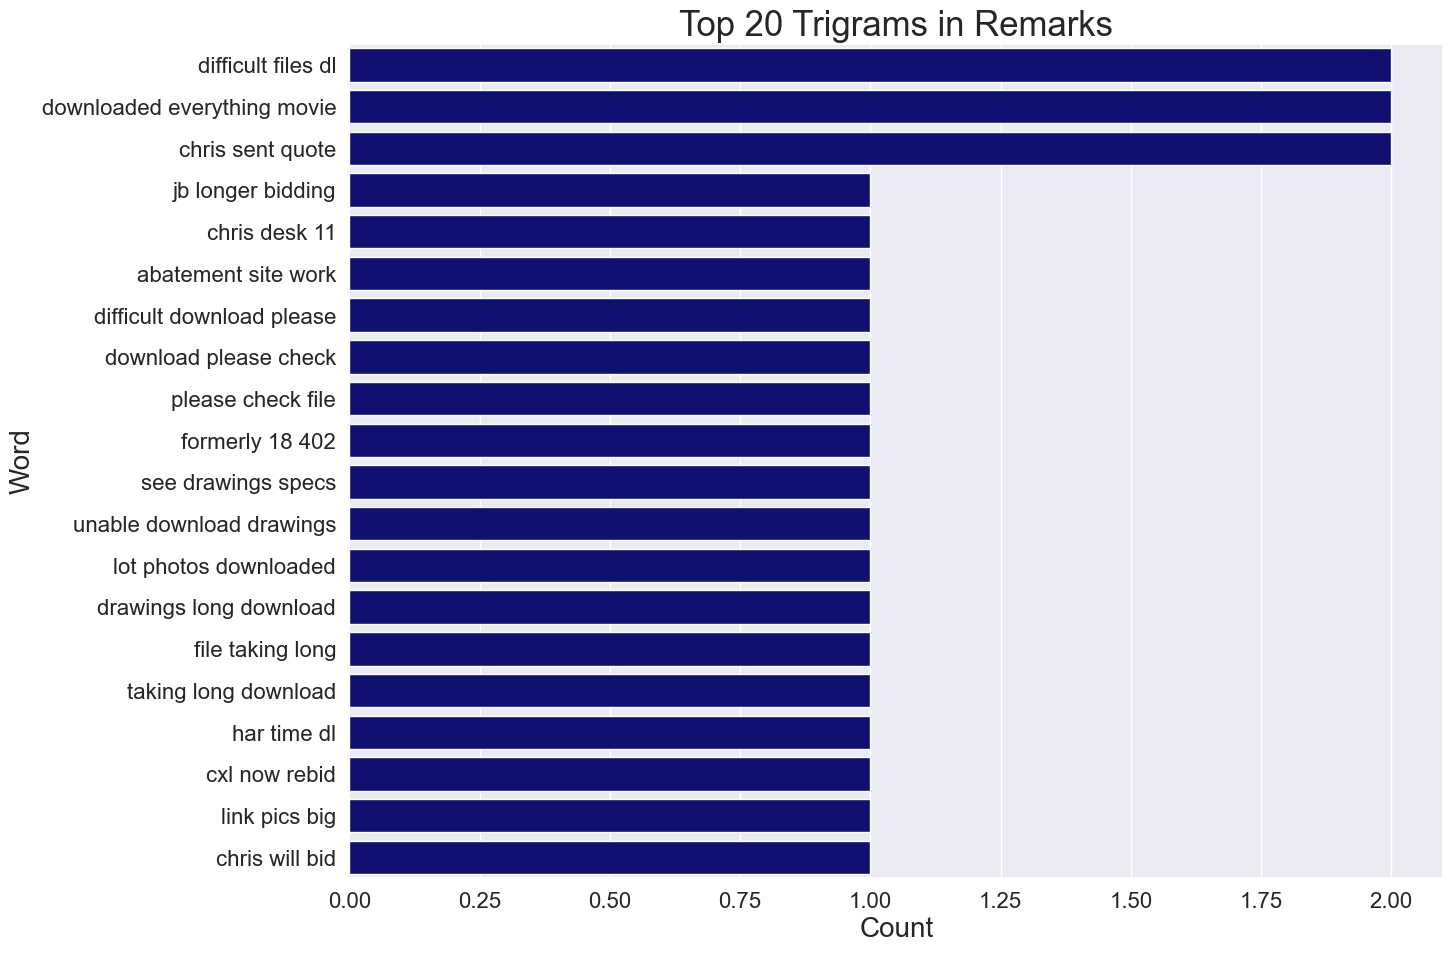

In [136]:
common_words = get_top_n_trigram(df['Remarks_cleaned'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['description Text' , 'count'])

sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="count", y="description Text", data=df1, color = 'navy', orient = 'h')
plt.title('Top 20 Trigrams in Remarks', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Count',fontsize=20)
plt.ylabel('Word',fontsize=20)
plt.tight_layout(pad=2)
plt.savefig("dabbco_toptrigrams.png", format="png")

In [137]:
dump(df,'training_df.joblib')

['training_df.joblib']

In [9]:
# Function to clean the "Description" field of a ticket
# Keep only alphanumeric values, strip extra space, keep it lowerspace
def process_descriptions(txt):
    return re.sub("[^a-zA-Z] +", "", txt).lower().strip()   

def get_traceback(e):
    lines = traceback.format_exception(type(e), e, e.__traceback__)
    return ''.join(lines)

In [10]:
# Columns to use for modeling -- NOT stakeholder given
model_cols = ['General_Contractor', 'Remarks', 'Addendum', 'EST', 'Results']
# Split the dataframe
res_df = df[model_cols]
res_df = res_df.loc[res_df['Results'] != 'nan']

classes = [1 if x == 'Awarded' else 0 for x in res_df['Results']]

In [11]:
# Create term counts and one hot encoding objects
vec = CountVectorizer(decode_error='ignore', strip_accents='unicode', lowercase=True, stop_words='english')
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse=False)

In [8]:
df_awarded = res_df[res_df["Results"] == 'Awarded']
df_not_awarded = res_df[res_df["Results"] == 'Not Awarded']

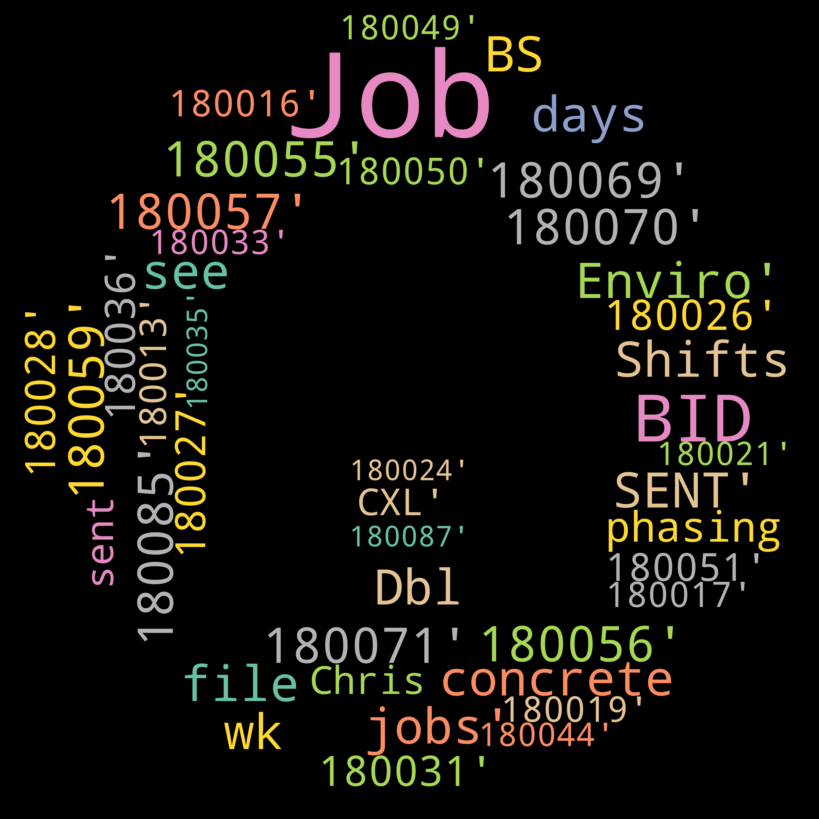

In [53]:
house_mask = np.array(Image.open("house_mask.png"))
text = df_awarded['Remarks'].values 

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=house_mask).generate(str(text))
plt.figure(figsize=(8, 8), facecolor="k")
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

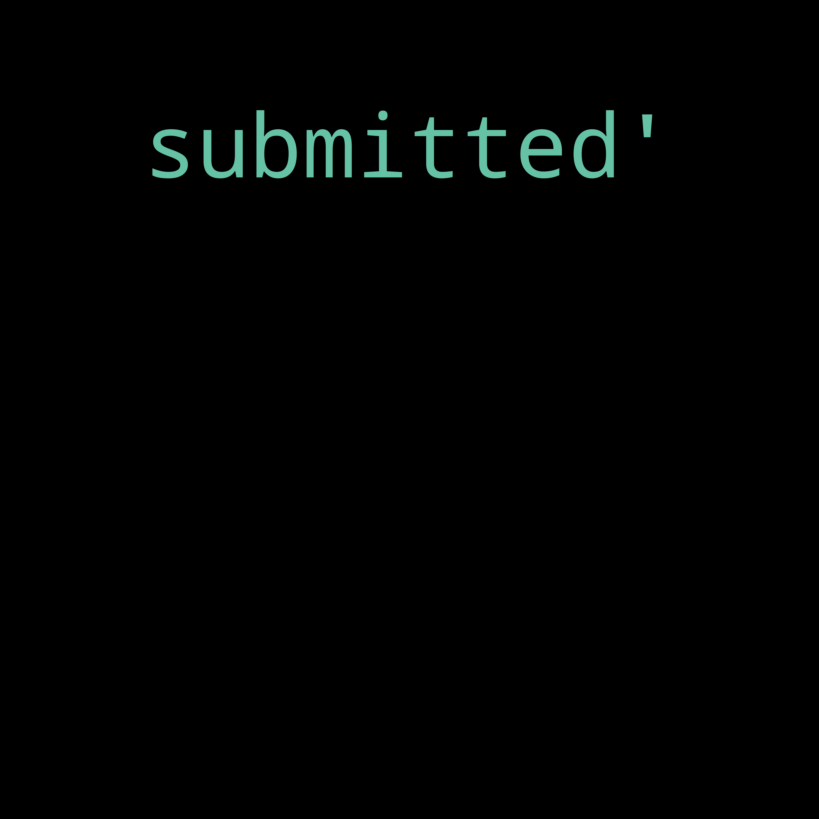

In [54]:
house_mask = np.array(Image.open("house_mask.png"))
text = df_not_awarded['Remarks'].values 

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=house_mask).generate(str(text))
plt.figure(figsize=(8, 8), facecolor="k")
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [12]:
model_cols

['General_Contractor', 'Remarks', 'Addendum', 'EST', 'Results']

In [13]:
# Transform the data
cat_data = pd.DataFrame(data=ohe.fit_transform(res_df[[x for x in model_cols if x not in ['Results', 'Remarks']]]), columns=list(ohe.get_feature_names_out()))
text_data = pd.DataFrame(data=vec.fit_transform(res_df['Remarks'].apply(process_descriptions)).todense(), columns=list(vec.get_feature_names_out()))
text_data = text_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

modeling_df = pd.concat([cat_data, text_data], axis=1)
modeling_df

General_Contractor_Argo Systems  General_Contractor_CBP Constructors, LLC  \
0                               0.0                                       0.0   
1                               0.0                                       0.0   
2                               0.0                                       0.0   
3                               0.0                                       0.0   
4                               0.0                                       0.0   
..                              ...                                       ...   
71                              0.0                                       0.0   
72                              0.0                                       0.0   
73                              0.0                                       0.0   
74                              0.0                                       0.0   
75                              0.0                                       0.0   

    General_Contractor_CYMA Builders of CM  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
..                                     ...   
71                                     0.0   
72                                     0.0   
73                                     0.0   
74                                     0.0   
75                                     0.0   

    General_Contractor_Consolidated Coatings  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
..                                       ...   
71                                       0.0   
72                                       0.0   
73                                       0.0   
74                                       0.0   
75                                       0.0   

    General_Contractor_Consolidated Medical Services  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
..                                               ...   
71                                               0.0   
72                                               0.0   
73                                               0.0   
74                                               0.0   
75                                               0.0   

    General_Contractor_Emaryland  General_Contractor_G & I Drywall  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            0.0                               0.0   
..                           ...                               ...   
71                           0.0                               0.0   
72                           0.0                               0.0   
73                           0.0                               0.0   
74                           0.0                               0.0   
75                           0.0                               0.0   

    General_Contractor_Herb Schafer Asphalt Pavement  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
..                                               ..

In [34]:
#dump(modeling_df,'encoded_training_df.joblib')
dump(X_train,'encoded_training_df.joblib')

['encoded_training_df.joblib']

In [14]:
modeling_df.columns

Index(['General_Contractor_Argo Systems',
       'General_Contractor_CBP Constructors, LLC',
       'General_Contractor_CYMA Builders of CM',
       'General_Contractor_Consolidated Coatings',
       'General_Contractor_Consolidated Medical Services',
       'General_Contractor_Emaryland', 'General_Contractor_G & I Drywall',
       'General_Contractor_Herb Schafer Asphalt Pavement',
       'General_Contractor_Jeffrey Brown Contracting, LLC',
       'General_Contractor_KasCon, Inc',
       'General_Contractor_Kimball Construction Company',
       'General_Contractor_Lewis Contractors',
       'General_Contractor_Lyons Construction',
       'General_Contractor_Mackenzie Contracting',
       'General_Contractor_Manekin', 'General_Contractor_Merrit Properties',
       'General_Contractor_Metropolitan Builders, Inc',
       'General_Contractor_No General Contractor Listed',
       'General_Contractor_North Point Builders',
       'General_Contractor_Oak Crest Village',
       'General_Contr

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(modeling_df, classes, stratify=classes, test_size=0.2, random_state=8)

In [14]:
# Get a list of classifiers
classifiers = [GaussianNB(), ComplementNB(), MultinomialNB(), BernoulliNB(),
              RandomForestClassifier(), AdaBoostClassifier(), ExtraTreesClassifier(),
              DecisionTreeClassifier(), ExtraTreeClassifier(),
              XGBClassifier(), SVC(probability=True), 
              MLPClassifier()]


    GaussianNB Predicted:
    -----------------------------------
    Late as Late: 83.3%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 16.7%
    


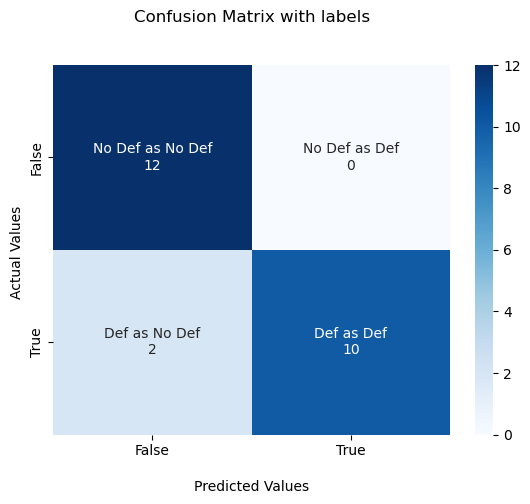

<Figure size 500x500 with 0 Axes>

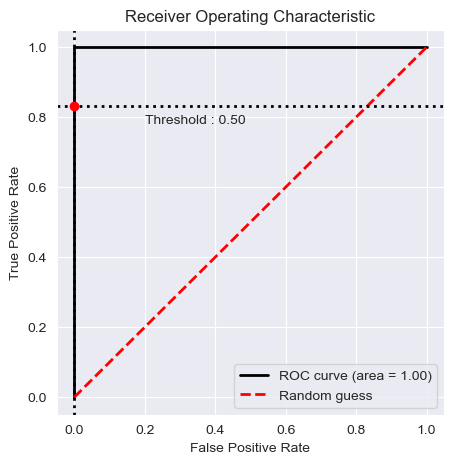

raw dabbco | REPORT FOR GaussianNB
Trained GaussianNB in 0.0021750926971435547

    
    Samples: 24
    Accuracy: 0.9166666666666666
    Balanced Accuracy: 0.9166666666666667
    F1 Macro: 0.916083916083916
    F1 Micro: 0.9166666666666666
    F1 Weighted: 0.9160839160839161
    F1 Averaged: [0.92307692 0.90909091]
    
    Report:               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.83      0.91        12

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24

    
    tp: 10
    fp: 0
    tn: 12
    fn: 2
    
-----------------------------------------------------------

    ComplementNB Predicted:
    -----------------------------------
    Late as Late: 75.0%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 25.0%
    


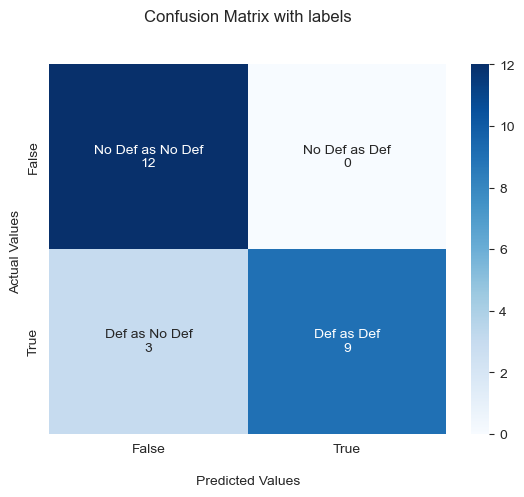

<Figure size 500x500 with 0 Axes>

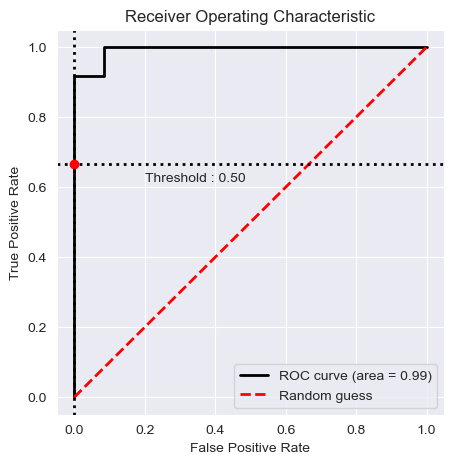

raw dabbco | REPORT FOR ComplementNB
Trained ComplementNB in 0.004606962203979492

    
    Samples: 24
    Accuracy: 0.875
    Balanced Accuracy: 0.875
    F1 Macro: 0.873015873015873
    F1 Micro: 0.875
    F1 Weighted: 0.873015873015873
    F1 Averaged: [0.88888889 0.85714286]
    
    Report:               precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.75      0.86        12

    accuracy                           0.88        24
   macro avg       0.90      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24

    
    tp: 9
    fp: 0
    tn: 12
    fn: 3
    
-----------------------------------------------------------

    MultinomialNB Predicted:
    -----------------------------------
    Late as Late: 75.0%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 25.0%
    


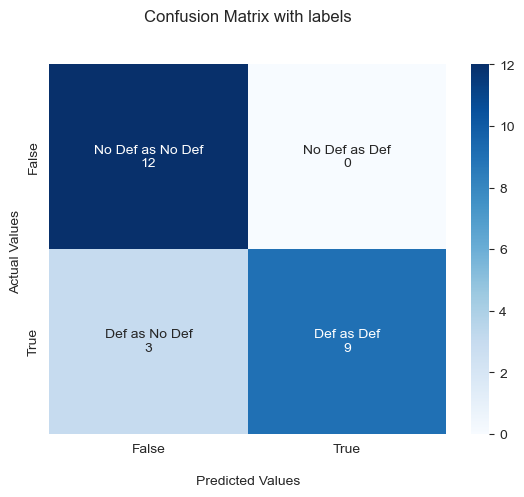

<Figure size 500x500 with 0 Axes>

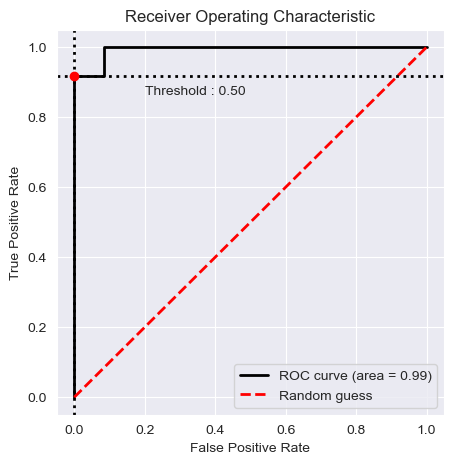

raw dabbco | REPORT FOR MultinomialNB
Trained MultinomialNB in 0.002938985824584961

    
    Samples: 24
    Accuracy: 0.875
    Balanced Accuracy: 0.875
    F1 Macro: 0.873015873015873
    F1 Micro: 0.875
    F1 Weighted: 0.873015873015873
    F1 Averaged: [0.88888889 0.85714286]
    
    Report:               precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.75      0.86        12

    accuracy                           0.88        24
   macro avg       0.90      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24

    
    tp: 9
    fp: 0
    tn: 12
    fn: 3
    
-----------------------------------------------------------

    BernoulliNB Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


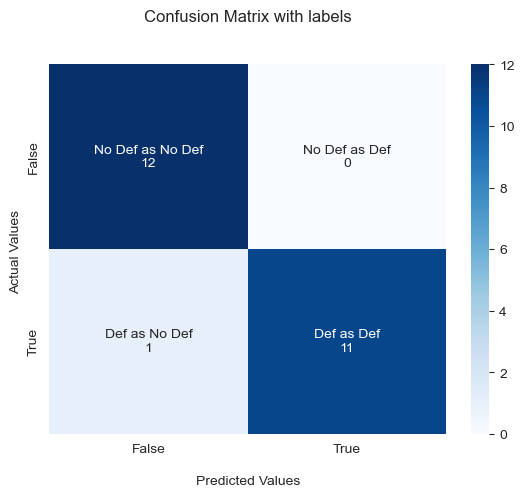

<Figure size 500x500 with 0 Axes>

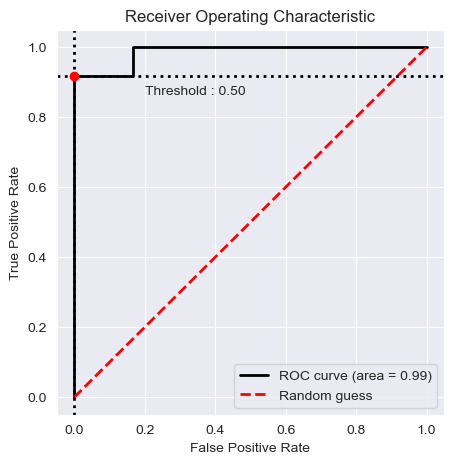

raw dabbco | REPORT FOR BernoulliNB
Trained BernoulliNB in 0.004380941390991211

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------

    RandomForestClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


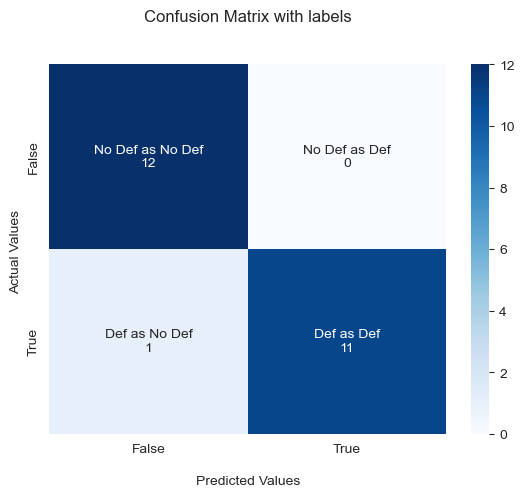

<Figure size 500x500 with 0 Axes>

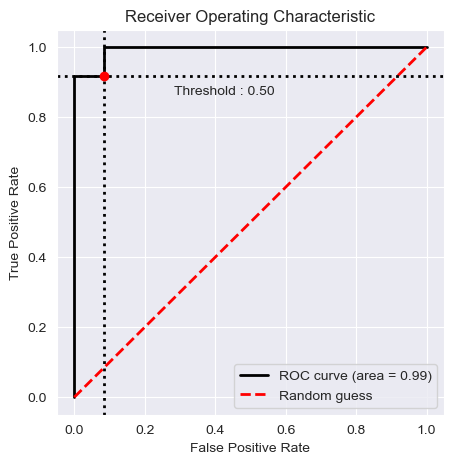

raw dabbco | REPORT FOR RandomForestClassifier
Trained RandomForestClassifier in 0.13423395156860352

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------

    AdaBoostClassifier Predicted:
    -----------------------------------
    Late as Late: 100.0%
    OT As OT: 83.3%
    OT As Late: 16.7%
    Late as On Time: 0.0%
    


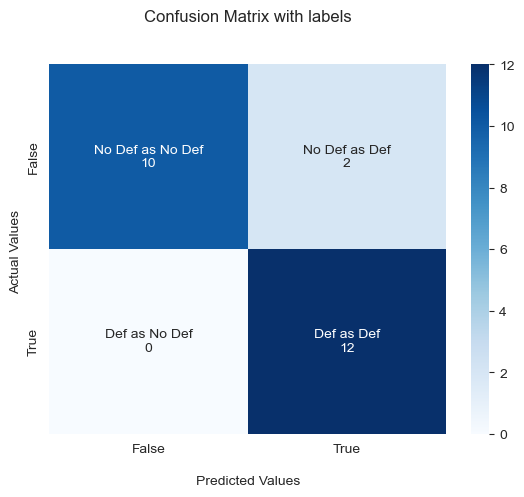

<Figure size 500x500 with 0 Axes>

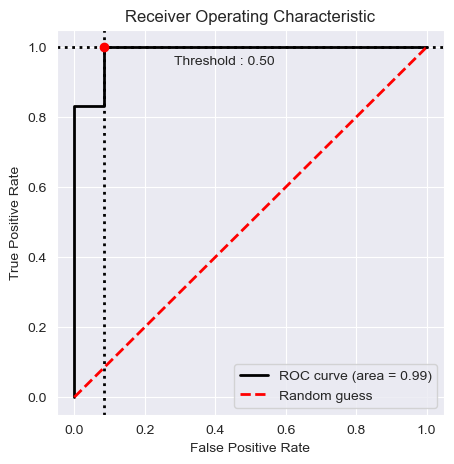

raw dabbco | REPORT FOR AdaBoostClassifier
Trained AdaBoostClassifier in 0.08173012733459473

    
    Samples: 24
    Accuracy: 0.9166666666666666
    Balanced Accuracy: 0.9166666666666667
    F1 Macro: 0.916083916083916
    F1 Micro: 0.9166666666666666
    F1 Weighted: 0.9160839160839161
    F1 Averaged: [0.90909091 0.92307692]
    
    Report:               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.86      1.00      0.92        12

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24

    
    tp: 12
    fp: 2
    tn: 10
    fn: 0
    
-----------------------------------------------------------

    ExtraTreesClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


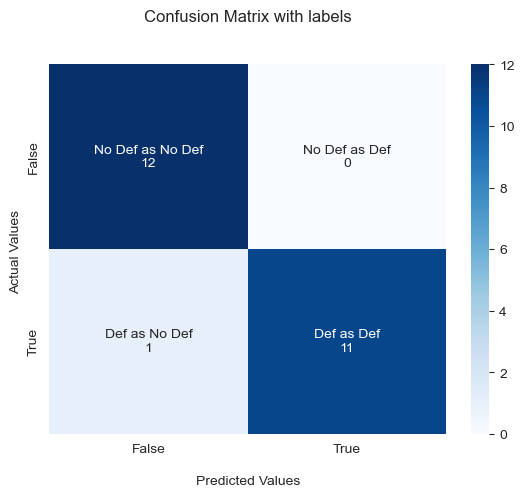

<Figure size 500x500 with 0 Axes>

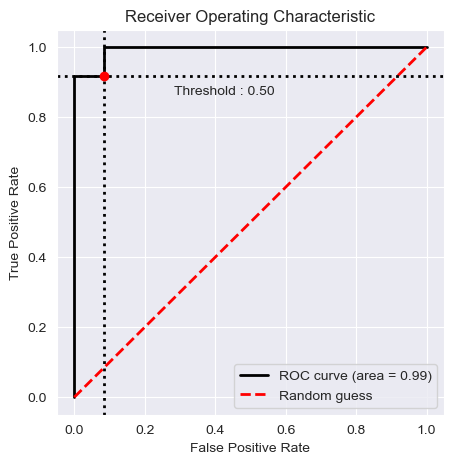

raw dabbco | REPORT FOR ExtraTreesClassifier
Trained ExtraTreesClassifier in 0.11171293258666992

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------

    DecisionTreeClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 91.7%
    OT As Late: 8.3%
    Late as On Time: 8.3%
    


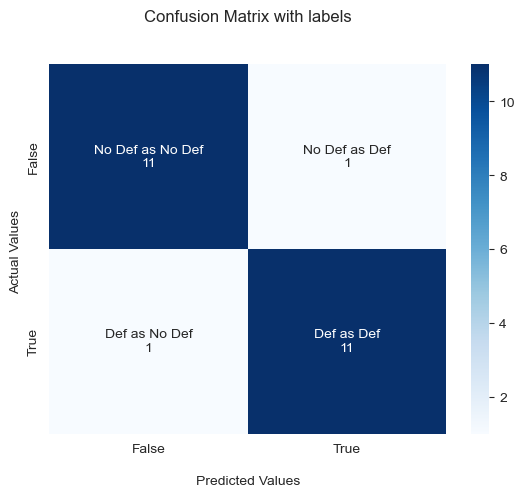

<Figure size 500x500 with 0 Axes>

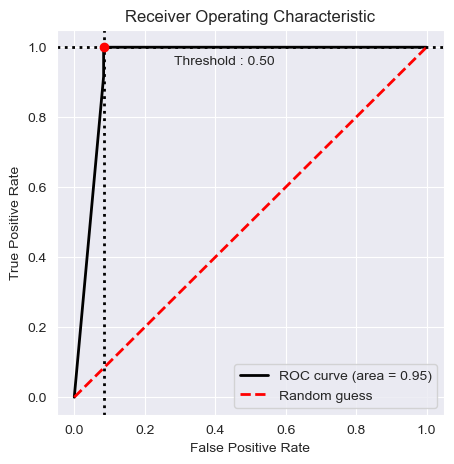

raw dabbco | REPORT FOR DecisionTreeClassifier
Trained DecisionTreeClassifier in 0.004263877868652344

    
    Samples: 24
    Accuracy: 0.9166666666666666
    Balanced Accuracy: 0.9166666666666666
    F1 Macro: 0.9166666666666666
    F1 Micro: 0.9166666666666666
    F1 Weighted: 0.9166666666666666
    F1 Averaged: [0.91666667 0.91666667]
    
    Report:               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.92      0.92      0.92        12

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24

    
    tp: 11
    fp: 1
    tn: 11
    fn: 1
    
-----------------------------------------------------------

    ExtraTreeClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 83.3%
    OT As Late: 16.7%
    Late as On Time: 8.3%
    


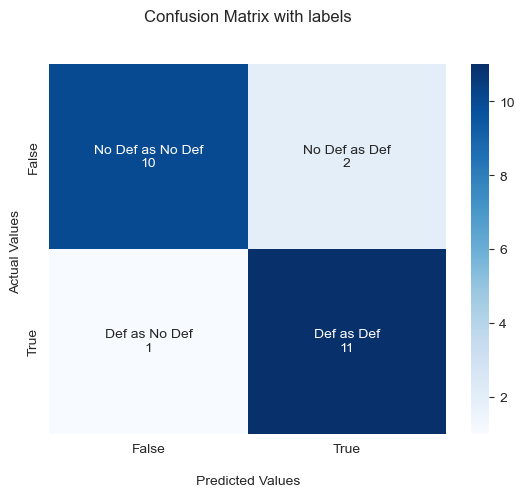

<Figure size 500x500 with 0 Axes>

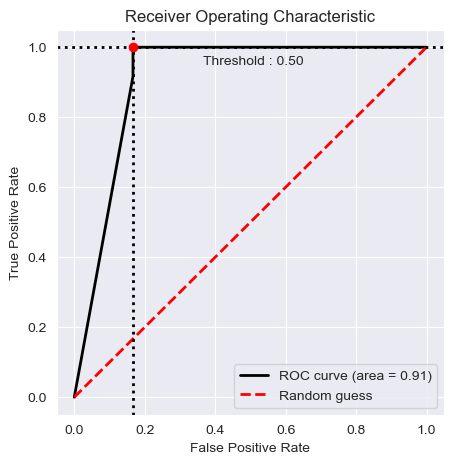

raw dabbco | REPORT FOR ExtraTreeClassifier
Trained ExtraTreeClassifier in 0.00427699089050293

    
    Samples: 24
    Accuracy: 0.875
    Balanced Accuracy: 0.875
    F1 Macro: 0.874782608695652
    F1 Micro: 0.875
    F1 Weighted: 0.8747826086956522
    F1 Averaged: [0.86956522 0.88      ]
    
    Report:               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.85      0.92      0.88        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24

    
    tp: 11
    fp: 2
    tn: 10
    fn: 1
    
-----------------------------------------------------------

    XGBClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


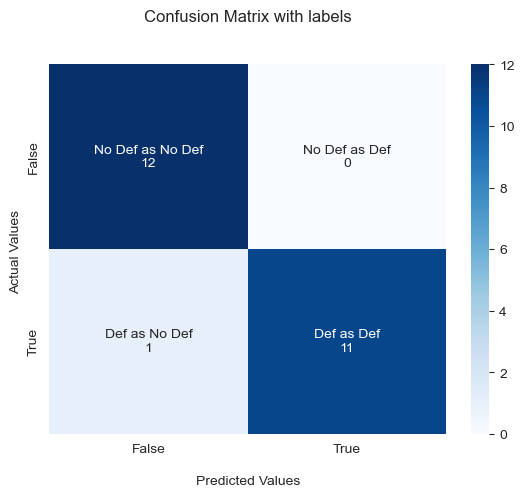

<Figure size 500x500 with 0 Axes>

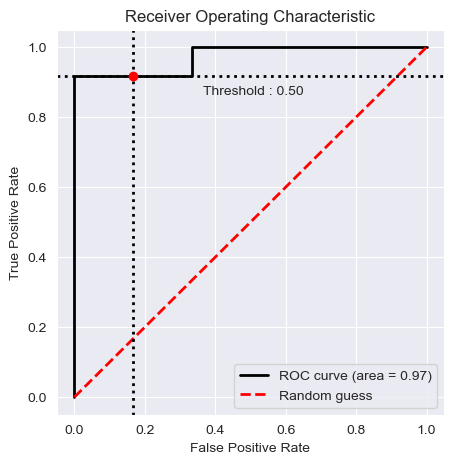

raw dabbco | REPORT FOR XGBClassifier
Trained XGBClassifier in 0.07717466354370117

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------

    SVC Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


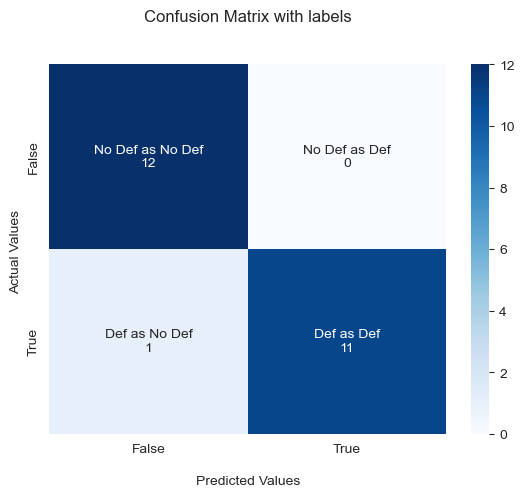

<Figure size 500x500 with 0 Axes>

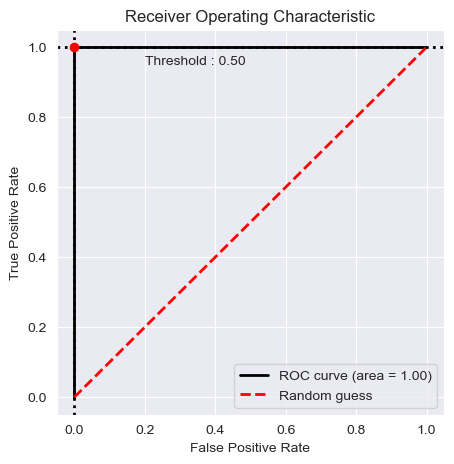

raw dabbco | REPORT FOR SVC
Trained SVC in 0.010354042053222656

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------

    MLPClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 100.0%
    OT As Late: 0.0%
    Late as On Time: 8.3%
    


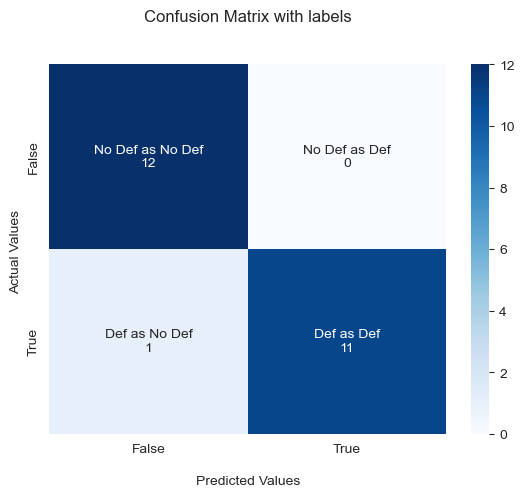

<Figure size 500x500 with 0 Axes>

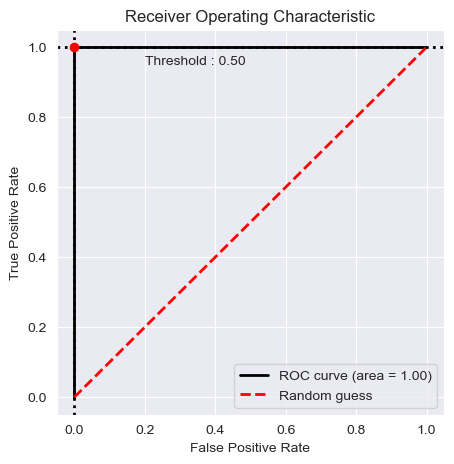

raw dabbco | REPORT FOR MLPClassifier
Trained MLPClassifier in 0.18433904647827148

    
    Samples: 24
    Accuracy: 0.9583333333333334
    Balanced Accuracy: 0.9583333333333333
    F1 Macro: 0.9582608695652175
    F1 Micro: 0.9583333333333334
    F1 Weighted: 0.9582608695652176
    F1 Averaged: [0.96       0.95652174]
    
    Report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

    
    tp: 11
    fp: 0
    tn: 12
    fn: 1
    
-----------------------------------------------------------


In [15]:
cols = ['Model Name', 'F1', 'Accuracy', 'Balanced Accuracy']
lst = []

# TL Sampler
#sampler = TomekLinks(sampling_strategy='not minority', n_jobs=8)
#sampler = RandomUnderSampler(random_state=42, replacement=True)
#sampler = RepeatedEditedNearestNeighbours(n_neighbors=3)
sampler = ADASYN()

# Resample the data
X, y = sampler.fit_resample(modeling_df, classes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=8)

for clf in classifiers:
    gc.collect()
    # Get the classifier's name
    clf_name = clf.__class__.__name__            
    # Fit it (turn to numpy for speed)
    train_start = time.time()
    clf.fit(X_train, y_train)
    train_stop = time.time()


    # Get predictions
    preds = clf.predict(X_test)
    
    # Record balanced accuracy, accuracy, and sklearn's classification report
    cnf_mtrx = confusion_matrix(y_test, preds, labels=[0, 1])
    bal_acc = balanced_accuracy_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    rpt = classification_report(y_test, preds)
    f1_mac = f1_score(y_test, preds, average='macro')
    f1_mic = f1_score(y_test, preds, average='micro')
    f1_weight = f1_score(y_test, preds, average='weighted')
    f1_avg = f1_score(y_test, preds, average=None)
    tp, fp, tn, fn = collect_metrics(y_test, preds)
    print_metrics(clf.__class__.__name__, tp, fp, tn, fn)
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, preds)
    group_names = ['No Def as No Def','No Def as Def','Def as No Def','Def as Def']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.figure(figsize=(5,5))
    plt.show()
    
    # Use predict_proba to predict probability of the class
    y_pred = clf.predict_proba(X_test)[:,1]
    
    # Box plots of model probabilities
    prob_df = probability_plot(clf, X_test, np.array(y_test).flatten())

#     plt.figure(figsize=(5,5))
#     sns.set(style="darkgrid")
#     sns.violinplot(y=prob_df['P_High'], x=prob_df['Correct Prediction'], hue=prob_df['Correct Prediction'],
#            orient='v', palette='dark', split=True).set(title="Violin Plot")

    # Figures
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()
    
    # Append dataframe list
    lst.append([clf_name, f1_weight, acc, bal_acc])
    
    # Create a pretty print string
    print_str = """
    
    Samples: {}
    Accuracy: {}
    Balanced Accuracy: {}
    F1 Macro: {}
    F1 Micro: {}
    F1 Weighted: {}
    F1 Averaged: {}
    
    Report: {}
    
    tp: {}
    fp: {}
    tn: {}
    fn: {}
    """.format(len(preds), acc, bal_acc, f1_mac, f1_mic, f1_weight, f1_avg, rpt, 
               tp, fp, tn, fn)  
    

    # Print results
    print("{} | REPORT FOR {}".format("raw dabbco", clf_name))
    print("Trained {} in {}".format(clf_name, train_stop-train_start))
    print(print_str)
    print("-----------------------------------------------------------")

In [16]:
df_results = pd.DataFrame(lst, columns=cols)
df_results

Model Name        F1  Accuracy  Balanced Accuracy
0               GaussianNB  0.916084  0.916667           0.916667
1             ComplementNB  0.873016  0.875000           0.875000
2            MultinomialNB  0.873016  0.875000           0.875000
3              BernoulliNB  0.958261  0.958333           0.958333
4   RandomForestClassifier  0.958261  0.958333           0.958333
5       AdaBoostClassifier  0.916084  0.916667           0.916667
6     ExtraTreesClassifier  0.958261  0.958333           0.958333
7   DecisionTreeClassifier  0.916667  0.916667           0.916667
8      ExtraTreeClassifier  0.874783  0.875000           0.875000
9            XGBClassifier  0.958261  0.958333           0.958333
10                     SVC  0.958261  0.958333           0.958333
11           MLPClassifier  0.958261  0.958333           0.958333

In [16]:
from collections import Counter

In [17]:
counter = Counter(classes)
print(counter)

Counter({1: 60, 0: 16})


In [18]:
#sampler = TomekLinks(sampling_strategy='majority', n_jobs=8)
#sampler = RandomUnderSampler(random_state=42, replacement=True)
#sampler = NearMiss(version=1, n_neighbors=3)
#sampler = RepeatedEditedNearestNeighbours(n_neighbors=3)
sampler = ADASYN()

# Resample the data
X, y = sampler.fit_resample(modeling_df, classes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=8)

In [19]:
counter = Counter(y)
print(counter)

Counter({1: 60, 0: 57})


In [21]:
gc.collect()

print("Getting ready to start randomized search...")
print()
print()
print()
print()

param_grid = {
    'max_depth': [6, 100, 500],
    'min_child_weight': [1, 10, 100],
    'gamma': [0, 1, 100],
    'max_delta_step': [0, 5, 10],
    'colsample_bytree': [0.5, 1],
    'colsample_bylevel': [0.5, 1],
    'colsample_bynode': [0.5, 1],
    # Determined
    'verbosity': [0], 
    'tree_method': ['auto'], 
    'subsample': [0.9], 
    'sampling_method': ['uniform'], 
    'predictor': ['cpu_predictor'], 
    'n_thread': [-1], 
    'grow_policy': ['depthwise'], 
    'eta': [0.3], 
    'booster': ['gbtree']
    
}

n_searches = 1
for x in [len(v) for k,v in param_grid.items()]:
    n_searches *= x

#n_searches *= 0.5
gs = RandomizedSearchCV(XGBClassifier(verbosity=0), param_distributions=param_grid, scoring={'RECALL': 'recall', 'PRECISION': 'precision', 'F1': 'f1'}, refit='F1', cv=3, n_jobs=16, verbose=2, n_iter=n_searches)
gs.fit(X, y)

cv_results = pd.DataFrame.from_dict(gs.cv_results_)
cv_df = cv_results[['params', 'mean_test_PRECISION', 'rank_test_PRECISION', 'mean_test_F1', 'rank_test_F1', 'mean_test_RECALL', 'rank_test_RECALL']]

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('expand_frame_repr', False)

cv_df.to_csv('xgboost_continuous_search_results_AUG.csv')

Getting ready to start randomized search...




Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=6, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.4s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=100, min_child_weight=100, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=6, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_by

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 booster=gbtree, colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=10, max_depth=500, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=1, grow_policy=depthwise, max_delta_step=0, max_depth=100, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=1, grow_policy=depthwise, max_delta_step=5, max_depth=6, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=1, col

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=100, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=6, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=500, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=6, min_child_weight=100, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=500, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.4s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=100, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=0, max_depth=100, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=6, min_child_weight=10, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.3s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, eta=0.3, gamma=0, grow_policy=depthwise, max_delta_step=5, max_depth=500, min_child_weight=1, n_thread=-1, predictor=cpu_predictor, sampling_method=uniform, subsample=0.9, tree_method=auto, verbosity=0; total time=   0.2s
[CV] END booster=gbtree, colsample_bylevel=0.5, colsample_b

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anaconda3/envs/bdv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandeepmundy/opt/anacond

In [ ]:
{'verbosity': 0, 'tree_method': 'auto', 'subsample': 0.9, 'sampling_method': 'uniform', 
 'predictor': 'cpu_predictor', 'n_thread': -1, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 
 'grow_policy': 'depthwise', 'gamma': 0, 'eta': 0.3, 'colsample_bytree': 1, 'colsample_bynode': 1, 
 'colsample_bylevel': 0.5, 'booster': 'gbtree'}

In [20]:
model = XGBClassifier(verbosity=0, tree_method='auto', subsample=0.9, sampling_method='uniform',
                     predictor='cpu_predictor', n_thread=-1, min_child_weight=1, max_depth=6,
                     max_delta_step=0, grow_policy='depthwise', gamma=0, eta=0.3, colsample_bytree=1,
                     colsample_bynode=0.5, colsample_bylevel=0.5, booster='gbtree')

In [21]:
# Train Model
model.fit(X_train, y_train)

# Get predictions
preds = model.predict(X_test)


    XGBClassifier Predicted:
    -----------------------------------
    Late as Late: 91.7%
    OT As OT: 83.3%
    OT As Late: 16.7%
    Late as On Time: 8.3%
    


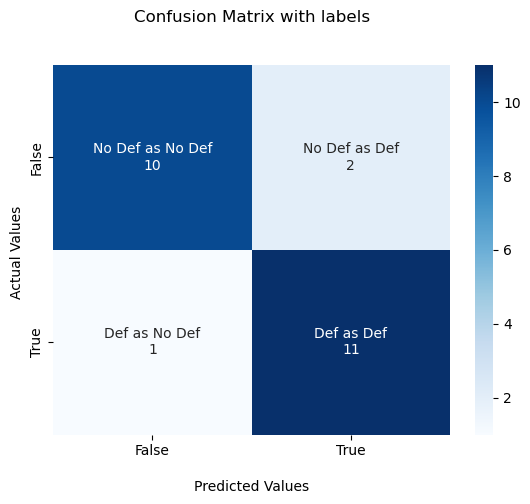

<Figure size 500x500 with 0 Axes>

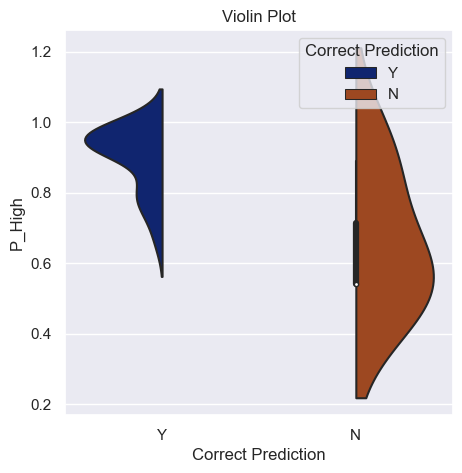

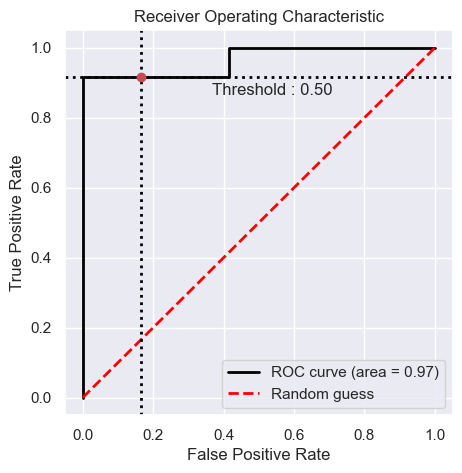

raw dabbco | REPORT FOR XGBClassifier
Trained XGBClassifier in 0.07971310615539551


Samples: 24
Accuracy: 0.875
Balanced Accuracy: 0.875
F1 Macro: 0.874782608695652
F1 Micro: 0.875
F1 Weighted: 0.8747826086956522
F1 Averaged: [0.86956522 0.88      ]

Report:               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.85      0.92      0.88        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24


tp: 11
fp: 2
tn: 10
fn: 1

-----------------------------------------------------------


In [22]:
gc.collect()
# Get the classifier's name
model_name = model.__class__.__name__            
# Fit it (turn to numpy for speed)
train_start = time.time()
model.fit(X_train, y_train)
train_stop = time.time()


# Get predictions
preds = model.predict(X_test)

# Record balanced accuracy, accuracy, and sklearn's classification report
cnf_mtrx = confusion_matrix(y_test, preds, labels=[0, 1])
bal_acc = balanced_accuracy_score(y_test, preds)
acc = accuracy_score(y_test, preds)
rpt = classification_report(y_test, preds)
f1_mac = f1_score(y_test, preds, average='macro')
f1_mic = f1_score(y_test, preds, average='micro')
f1_weight = f1_score(y_test, preds, average='weighted')
f1_avg = f1_score(y_test, preds, average=None)
tp, fp, tn, fn = collect_metrics(y_test, preds)
print_metrics(model.__class__.__name__, tp, fp, tn, fn)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)
group_names = ['No Def as No Def','No Def as Def','Def as No Def','Def as Def']
group_counts = ["{0:0.0f}".format(value) for value in
            cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.figure(figsize=(5,5))
plt.show()

# Use predict_proba to predict probability of the class
y_pred = model.predict_proba(X_test)[:,1]

# Box plots of model probabilities
prob_df = probability_plot(model, X_test, np.array(y_test).flatten())

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
sns.violinplot(y=prob_df['P_High'], x=prob_df['Correct Prediction'], hue=prob_df['Correct Prediction'],
       orient='v', palette='dark', split=True).set(title="Violin Plot")

# Figures
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Create a pretty print string
print_str = """

Samples: {}
Accuracy: {}
Balanced Accuracy: {}
F1 Macro: {}
F1 Micro: {}
F1 Weighted: {}
F1 Averaged: {}

Report: {}

tp: {}
fp: {}
tn: {}
fn: {}
""".format(len(preds), acc, bal_acc, f1_mac, f1_mic, f1_weight, f1_avg, rpt, 
           tp, fp, tn, fn)  


# Print results
print("{} | REPORT FOR {}".format("raw dabbco", model_name))
print("Trained {} in {}".format(model_name, train_stop-train_start))
print(print_str)
print("-----------------------------------------------------------")

In [25]:
dump(model, 'xgb_model.joblib')

['xgb_model.joblib']

In [23]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

In [27]:
dump(shap_values, 'shap_values.joblib')
dump(explainer, 'explainer.joblib')

['explainer.joblib']

In [28]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
feature_importance

col_name  feature_importance_vals
38                                             EST_KE                 0.283826
39                            EST_No Estimator Listed                 0.098268
34                                         Addendum_1                 0.062948
75                                                job                 0.060559
8   General_Contractor_Jeffrey Brown Contracting, LLC                 0.052121
14                         General_Contractor_Manekin                 0.047715
33      General_Contractor_Whiting-Turner Contracting                 0.046819
23      General_Contractor_Riparius Construction, Inc                 0.035992
24         General_Contractor_Shade Construction, Inc                 0.034200
11               General_Contractor_Lewis Contractors                 0.000523
10    General_Contractor_Kimball Construction Company                 0.000149
61                                             180059                 0.000000
60                                             180057                 0.000000
59                                             180056                 0.000000
58                                             180055                 0.000000
57                                             180051                 0.000000
54                                             180044                 0.000000
56                                             180050                 0.000000
55                                             180049                 0.000000
63                                             180070                 0.000000
53                                           18003cxl                 0.000000
52                                             180036                 0.000000
51                                             180035                 0.000000
50                                             180033                 0.000000
49                                             180031                 0.000000
62                                             180069                 0.000000
0                     General_Contractor_Argo Systems                 0.000000
64                                             180071                 0.000000
73                                             enviro                 0.000000
81                                          submitted                 0.000000
80                                             shifts                 0.000000
79                                               sent                 0.000000
78                                         phasingjob                 0.000000
77                                            onlybid                 0.000000
76                                               jobs                 0.000000
74                                               file                 0.000000
72                                                dbl                 0.000000
47                                             180027                 0.000000
71                                               days                 0.000000
70                                           concrete                 0.000000
69                                              chris                 0.000000
68                                                 bs                 0.000000
67                                             bidjob                 0.000000
66                                             180087                 0.000000
65                                             180085                 0.000000
48                                             180028                 0.000000
41                                             180016                 0.000000
46                                             180026                 0.000000
45                                             180024                 0.000000
20                General_Contractor_Plano-Coudon LLC                 0.000000
19              

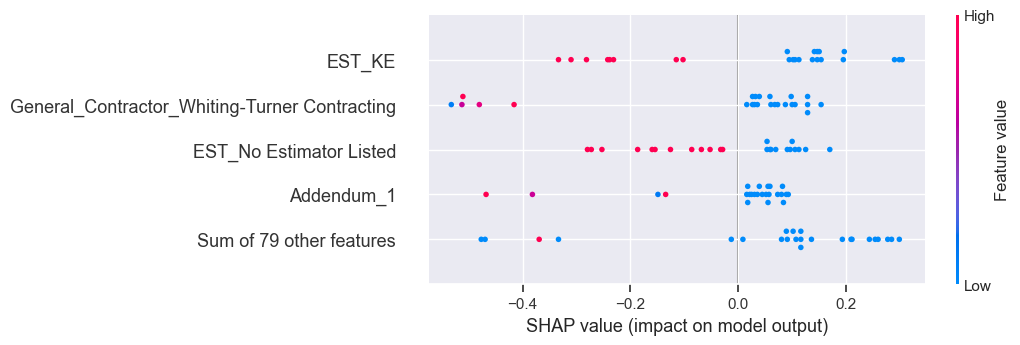

In [25]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values, max_display=5)
plt.show()

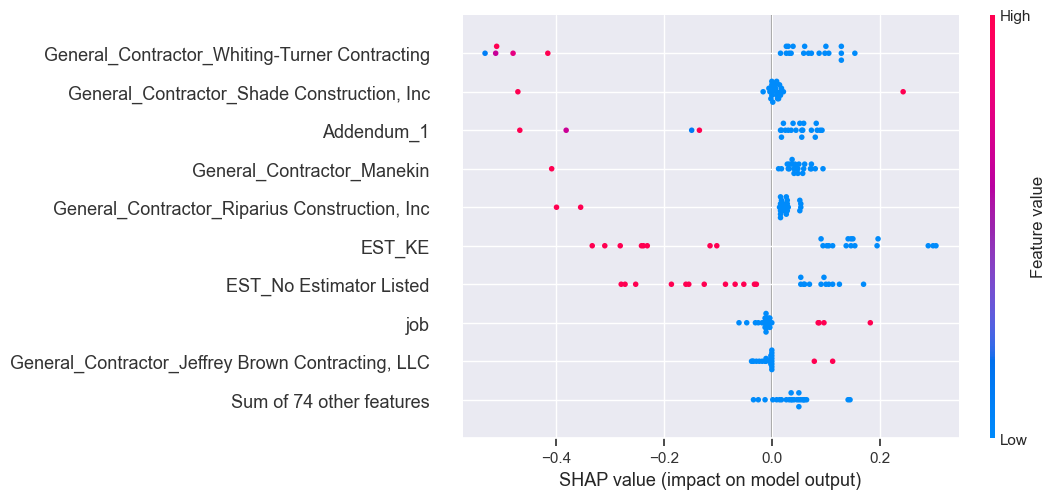

In [26]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

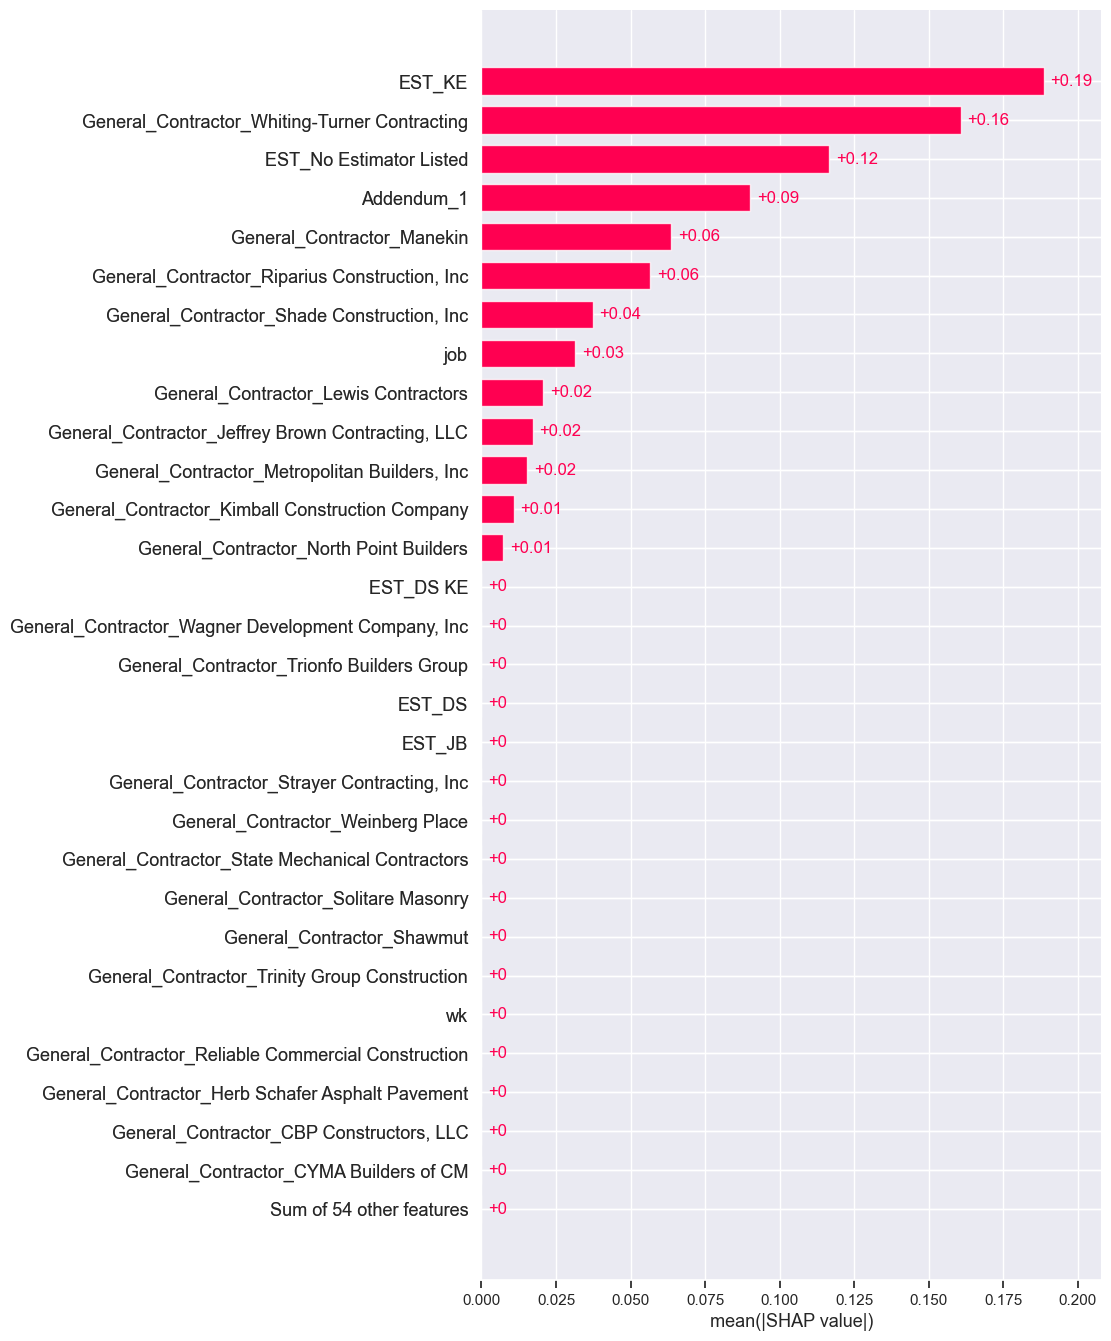

In [24]:
shap.plots.bar(shap_values, max_display=30)

In [154]:
explainer = shap.KernelExplainer(clf.predict_proba, shap.kmeans(X_train, 5))
gc.collect()
shap_values = explainer.shap_values(X_test.head(n=10000))

  0%|          | 0/15 [00:00<?, ?it/s]

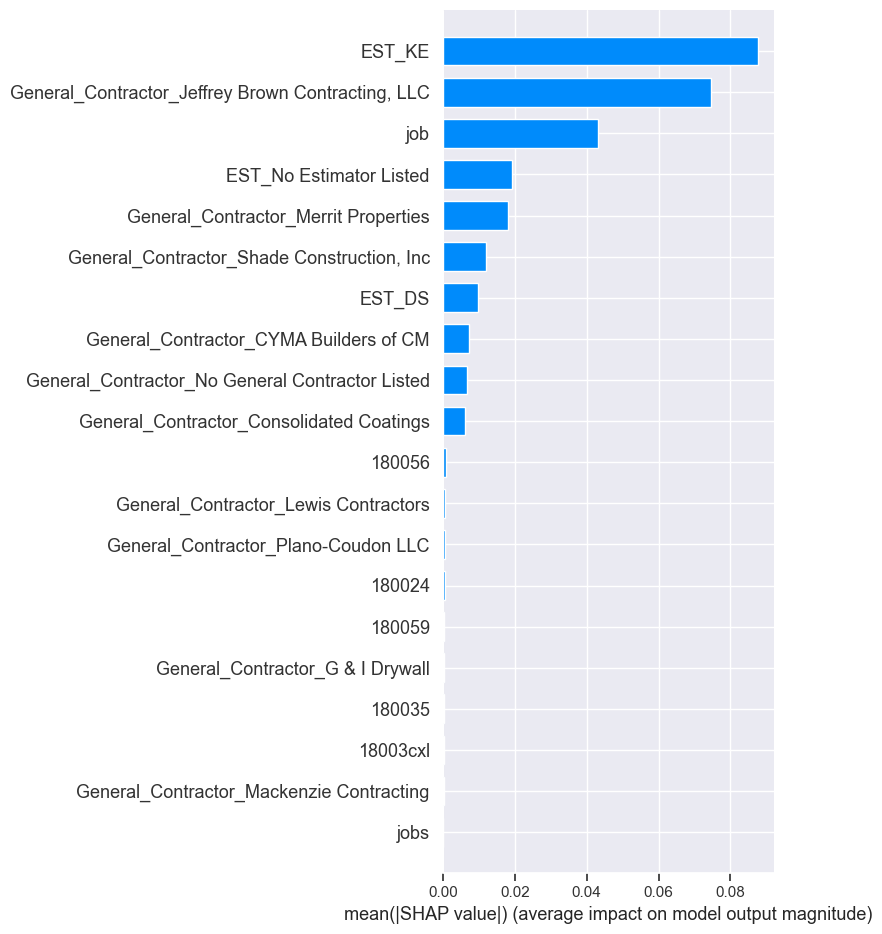

In [157]:
shap.summary_plot(shap_values[1], 
                  title="Model Feature Importances", feature_names = X_train.columns, 
                  plot_type='bar', max_display=20)

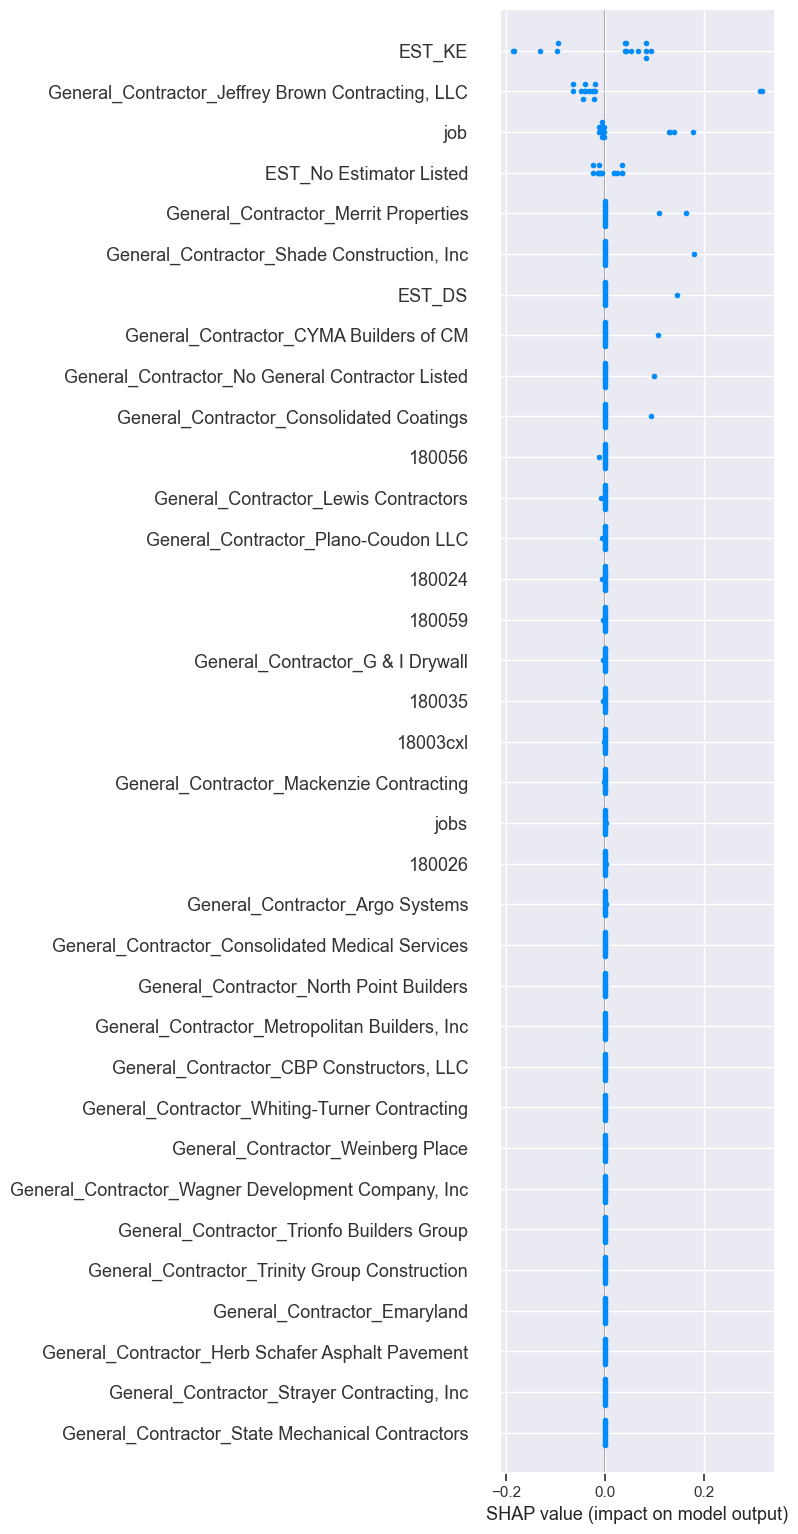

In [159]:
shap.summary_plot(shap_values[1], feature_names = X_train.columns, max_display=35)